# EmployeePayHistory

## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from torch.utils.data import TensorDataset, DataLoader
from common_functions import drop_sk_datetime_added_columns as drop_columns, train_model, get_engine, \
    read_data_return_df, plot_predictions, plot_feature_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import torch

## Connecting to the database
Connecting to the UnitedOutdoors sql server database and reading the data from the EmployeePayHistory table

In [2]:
engine = get_engine()

Connection to UnitedOutdoors database successful


## Reading in the data

In [3]:
sql_query_employeepayhistory = "SELECT * FROM EmployeePayHistory"
employeepayhistory_df = read_data_return_df(sql_query_employeepayhistory, engine)

employeepayhistory_df.head()

,EMPLOYEEPAYHISTORY_sk,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate,EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency,EMPLOYEEPAYHISTORY_datetime_added
0,1,508,2009-01-14,125.5000,2,2024-05-26 17:15:07.033
1,2,659,2008-01-31,63.4615,2,2024-05-26 17:15:07.033
2,3,890,2007-11-11,43.2692,2,2024-05-26 17:15:07.033
3,4,660,2007-12-05,8.6200,2,2024-05-26 17:15:07.033
4,5,660,2010-05-31,23.7200,2,2024-05-26 17:15:07.033


In [4]:
sql_query_businessentity = "SELECT * FROM BusinessEntity"
businessentity_df = read_data_return_df(sql_query_businessentity, engine)

businessentity_df.head()

,BUSINESSENTITY_sk,BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID,BUSINESSENTITY_BUSINESSENTITYCONTACT_PersonID,BUSINESSENTITY_CONTACTTYPE_ContactTypeID,BUSINESSENTITY_CONTACTTYPE_Name,BUSINESSENTITY_datetime_added
0,1,NaN,NaN,1.0,Accounting Manager,2024-05-26 17:14:05.540
1,2,1510.0,1509.0,2.0,Assistant Sales Agent,2024-05-26 17:14:05.540
2,3,1518.0,1517.0,2.0,Assistant Sales Agent,2024-05-26 17:14:05.540
3,4,1522.0,1521.0,2.0,Assistant Sales Agent,2024-05-26 17:14:05.540
4,5,1528.0,1527.0,2.0,Assistant Sales Agent,2024-05-26 17:14:05.540


In [5]:
sql_query_employee = "SELECT EMPLOYEE_EMPLOYEE_EmployeeID, EMPLOYEE_EMPLOYEE_ManagerID, EMPLOYEE_EMPLOYEE_DeptID, EMPLOYEE_EMPLOYEE_State, EMPLOYEE_EMPLOYEE_Start_Date, EMPLOYEE_EMPLOYEE_OrganizationLevel, EMPLOYEE_EMPLOYEE_BirthDate, EMPLOYEE_EMPLOYEE_SickLeaveHours FROM Employee"
employee_df = read_data_return_df(sql_query_employee, engine)

employee_df.head()

,EMPLOYEE_EMPLOYEE_EmployeeID,EMPLOYEE_EMPLOYEE_ManagerID,EMPLOYEE_EMPLOYEE_DeptID,EMPLOYEE_EMPLOYEE_State,EMPLOYEE_EMPLOYEE_Start_Date,EMPLOYEE_EMPLOYEE_OrganizationLevel,EMPLOYEE_EMPLOYEE_BirthDate,EMPLOYEE_EMPLOYEE_SickLeaveHours
0,1,NaN,NaN,None,None,NaN,1969-01-29,69.0
1,2,NaN,NaN,None,None,1.0,1971-08-01,20.0
2,3,NaN,NaN,None,None,2.0,1974-11-12,21.0
3,4,NaN,NaN,None,None,3.0,1974-12-23,80.0
4,5,NaN,NaN,None,None,3.0,1952-09-27,22.0


## Data Cleaning

In [6]:
# combining the dataframes
combined_df = pd.merge(employeepayhistory_df ,businessentity_df, left_on='EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_BusinessEntityID', right_on='BUSINESSENTITY_sk', suffixes=('_eph', '_b'))

combined_df = pd.merge(combined_df, employee_df, left_on='BUSINESSENTITY_BUSINESSENTITY_BusinessEntityID', right_on='EMPLOYEE_EMPLOYEE_EmployeeID', suffixes=('', '_e'), how='outer')

In [7]:
# dropping unnecessary columns
columns_to_keep = ['EMPLOYEE_EMPLOYEE_EmployeeID', 'EMPLOYEE_EMPLOYEE_ManagerID', 'EMPLOYEE_EMPLOYEE_DeptID', 'EMPLOYEE_EMPLOYEE_State', 'EMPLOYEE_EMPLOYEE_BirthDate', 'EMPLOYEE_EMPLOYEE_Start_Date', 'EMPLOYEE_EMPLOYEE_OrganizationLevel', 'EMPLOYEE_EMPLOYEE_SickLeaveHours', 'EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate', 'EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_PayFrequency', 'BUSINESSENTITY_CONTACTTYPE_ContactTypeID', 'EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate']

combined_df = combined_df[columns_to_keep]

In [8]:
# converting EMPLOYEE_EMPLOYEE_State
combined_df['EMPLOYEE_EMPLOYEE_State'] = combined_df['EMPLOYEE_EMPLOYEE_State'].astype('category').cat.codes

# Convert the datetime column to number of days since Unix epoch
combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = pd.to_datetime(combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'], errors='coerce')
combined_df['EMPLOYEE_EMPLOYEE_BirthDate'] = pd.to_datetime(combined_df['EMPLOYEE_EMPLOYEE_BirthDate'], errors='coerce')
combined_df['EMPLOYEE_EMPLOYEE_Start_Date'] = pd.to_datetime(combined_df['EMPLOYEE_EMPLOYEE_Start_Date'], errors='coerce')

# Convert the datetime objects to number of days since Unix epoch
combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] = (combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_RateChangeDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
combined_df['EMPLOYEE_EMPLOYEE_BirthDate'] = (combined_df['EMPLOYEE_EMPLOYEE_BirthDate'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
combined_df['EMPLOYEE_EMPLOYEE_Start_Date'] = (combined_df['EMPLOYEE_EMPLOYEE_Start_Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')

In [9]:
# fixing null values
drop_columns(combined_df)

# dropping all rows where EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate is null/-1
combined_df = combined_df[combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'] != -1]

In [10]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 402 to 744
Data columns (total 12 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   EMPLOYEE_EMPLOYEE_EmployeeID                          321 non-null    float64
 1   EMPLOYEE_EMPLOYEE_ManagerID                           321 non-null    float64
 2   EMPLOYEE_EMPLOYEE_DeptID                              321 non-null    float64
 3   EMPLOYEE_EMPLOYEE_State                               321 non-null    int8   
 4   EMPLOYEE_EMPLOYEE_BirthDate                           321 non-null    float64
 5   EMPLOYEE_EMPLOYEE_Start_Date                          321 non-null    float64
 6   EMPLOYEE_EMPLOYEE_OrganizationLevel                   321 non-null    float64
 7   EMPLOYEE_EMPLOYEE_SickLeaveHours                      321 non-null    float64
 8   EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate            321 non-n

## Data Analysis
Predicting the rate of pay for employees based on the other columns, using a variety of models

### Splitting the data

In [11]:
# splitting the data
X = combined_df.drop(columns=['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate'])
y = combined_df['EMPLOYEEPAYHISTORY_EMPLOYEEPAYHISTORY_Rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [12]:
# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# fitting the model
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [14]:
# predicting the values
lr_y_pred = lr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [15]:
# calculating the metrics
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Mean Squared Error: {lr_mse}')
print(f'R2 Score: {lr_r2}')

Mean Squared Error: 70.70585121241156
R2 Score: 0.3078934297922168


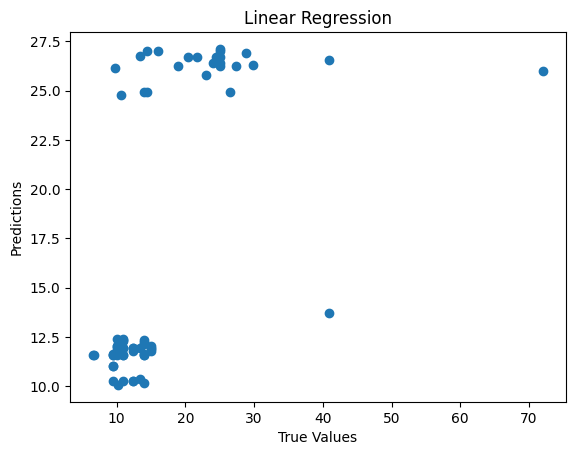

In [16]:
# visualizing the results
plot_predictions(y_test, lr_y_pred, 'Linear Regression')

In [17]:
# dataframe with the predictions and the actual values, plus other metrics
lr_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_y_pred})
lr_results['Difference'] = lr_results['Actual'] - lr_results['Predicted']
lr_results['Absolute Difference'] = np.abs(lr_results['Difference'])
lr_results['Squared Difference'] = lr_results['Difference'] ** 2

lr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
591,14.4231,27.023967,-12.600867,12.600867,158.781843
541,20.4327,26.704141,-6.271441,6.271441,39.330972
615,11.0000,12.358168,-1.358168,1.358168,1.844621
411,24.0000,26.390728,-2.390728,2.390728,5.715580
513,14.0000,11.608860,2.391140,2.391140,5.717552
...,...,...,...,...,...
649,16.0000,27.019043,-11.019043,11.019043,121.419300
467,11.0000,11.603232,-0.603232,0.603232,0.363889
713,13.9423,24.925010,-10.982710,10.982710,120.619922
684,11.0000,11.939941,-0.939941,0.939941,0.883488


In [18]:
# printing the average absolute difference
print(f'Average Absolute Difference: {lr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 4.559253313261292


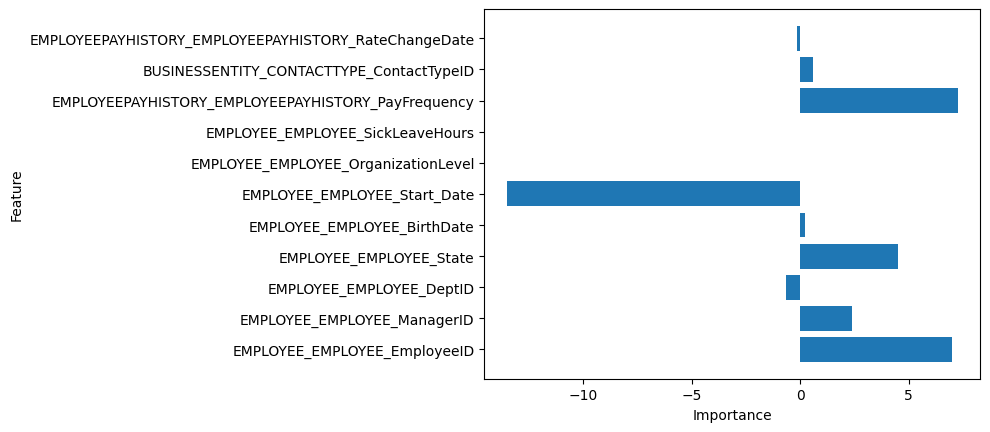

In [19]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, lr_model.coef_)

### Decision Tree Regressor

In [20]:
# fitting the model
dtr_model = DecisionTreeRegressor(max_depth=5)

dtr_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=5)

In [21]:
# predicting the values
dtr_y_pred = dtr_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [22]:
# calculating the metrics
dtr_mse = mean_squared_error(y_test, dtr_y_pred)
dtr_r2 = r2_score(y_test, dtr_y_pred)
print(f'Mean Squared Error: {dtr_mse}')
print(f'R2 Score: {dtr_r2}')

Mean Squared Error: 63.74267275251074
R2 Score: 0.3760527331453275


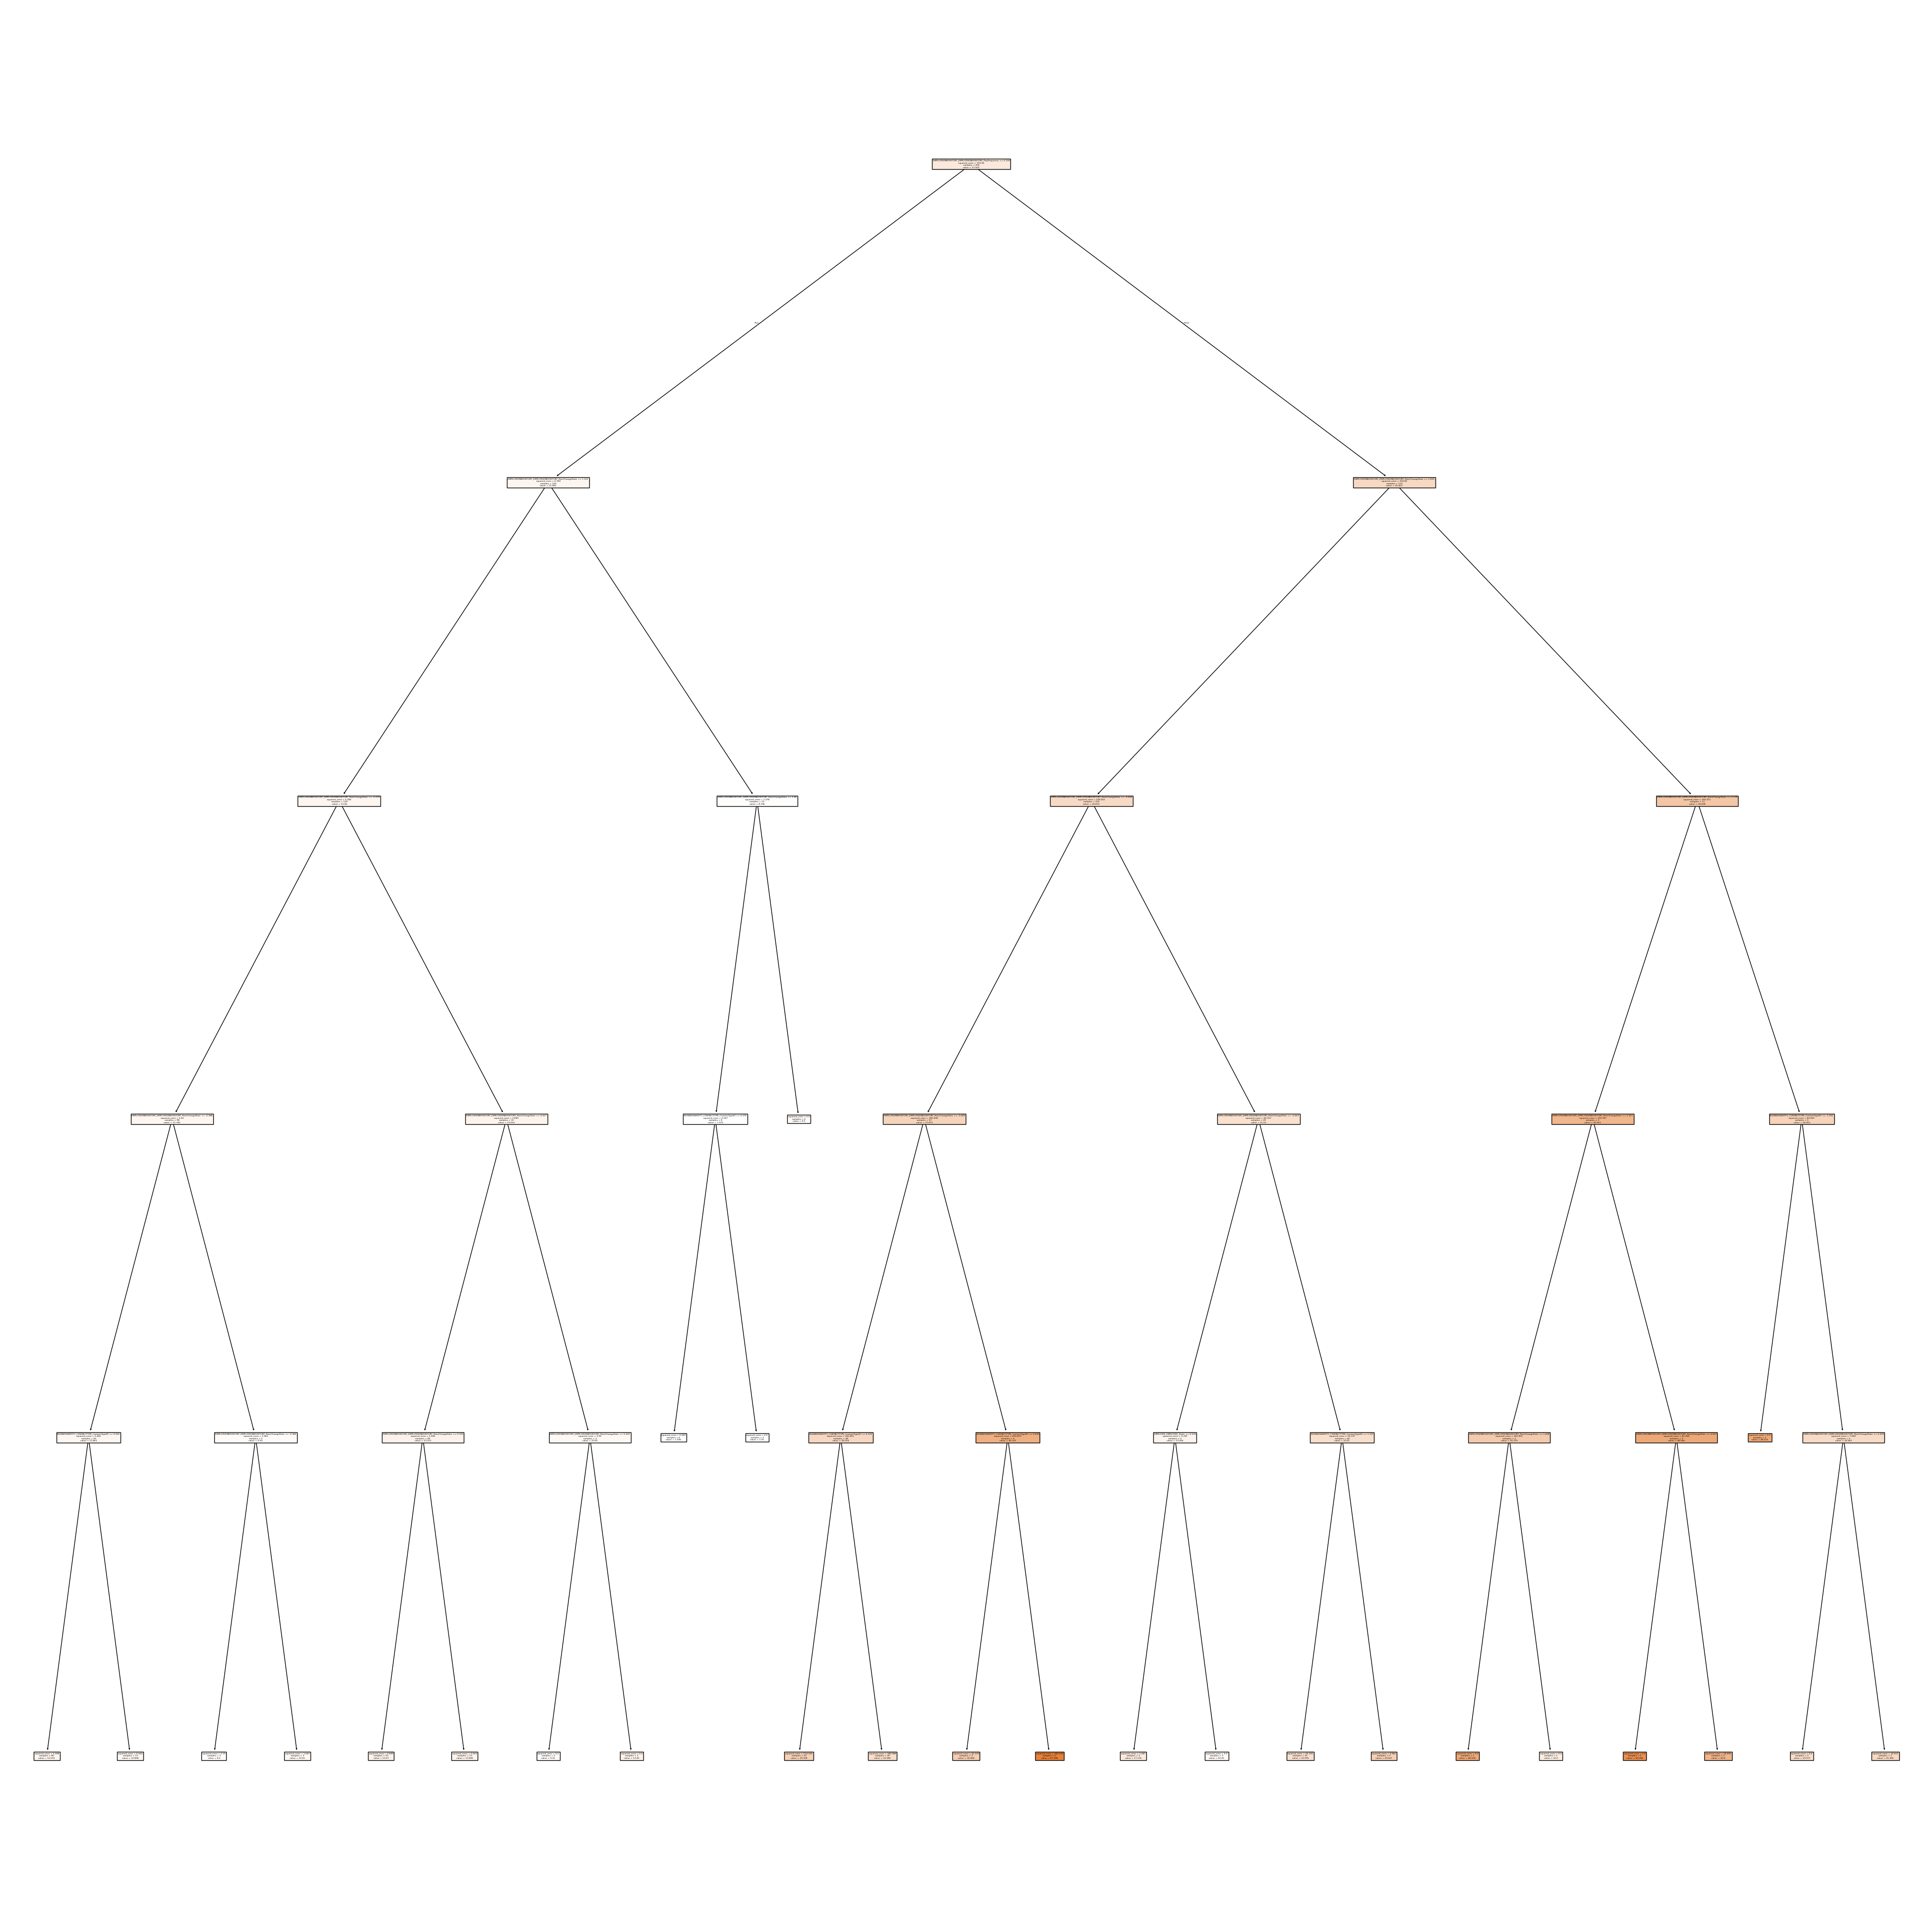

In [23]:
# visualizing the decision tree
plt.figure(figsize=(50, 50))
plot_tree(dtr_model, filled=True, feature_names=X.columns)
plt.show()

In [24]:
# dataframe with the predictions and the actual values, plus other metrics
dtr_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_y_pred})
dtr_results['Difference'] = dtr_results['Actual'] - dtr_results['Predicted']
dtr_results['Absolute Difference'] = np.abs(dtr_results['Difference'])
dtr_results['Squared Difference'] = dtr_results['Difference'] ** 2

dtr_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
591,14.4231,23.283535,-8.860435,8.860435,78.507302
541,20.4327,23.283535,-2.850835,2.850835,8.127258
615,11.0000,10.807692,0.192308,0.192308,0.036982
411,24.0000,29.328445,-5.328445,5.328445,28.392331
513,14.0000,12.032500,1.967500,1.967500,3.871056
...,...,...,...,...,...
649,16.0000,23.283535,-7.283535,7.283535,53.049876
467,11.0000,12.032500,-1.032500,1.032500,1.066056
713,13.9423,30.689100,-16.746800,16.746800,280.455310
684,11.0000,12.032500,-1.032500,1.032500,1.066056


In [25]:
# printing the average absolute difference
print(f'Average Absolute Difference: {dtr_results["Absolute Difference"].mean()}')

Average Absolute Difference: 4.120350905504752


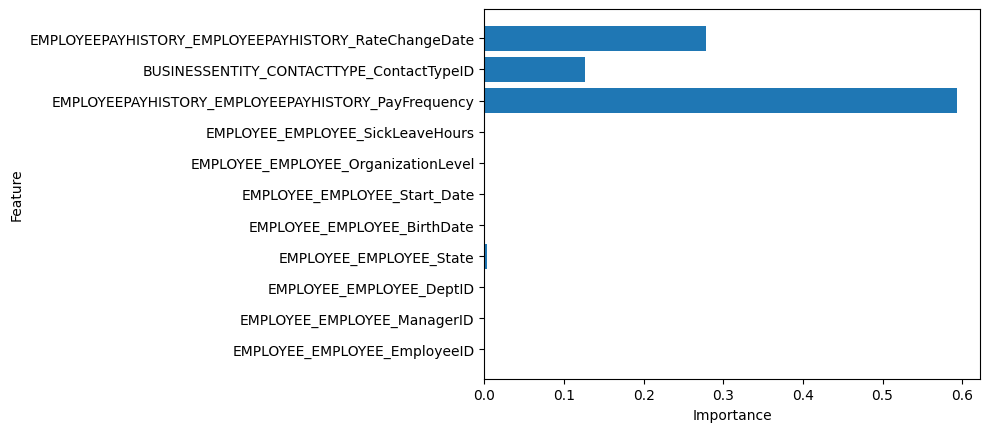

In [26]:
# plotting the feature importances, which means how much each column contributes to the prediction
plot_feature_importance(X.columns, dtr_model.feature_importances_)

### Random Forest

In [27]:
# fitting the model
rf_model = RandomForestRegressor(n_estimators=100)

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [28]:
# predicting the values
rf_y_pred = rf_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [29]:
# calculating the metrics
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
print(f'Mean Squared Error: {rf_mse}')
print(f'R2 Score: {rf_r2}')

Mean Squared Error: 91.59775669042612
R2 Score: 0.10339231994693032


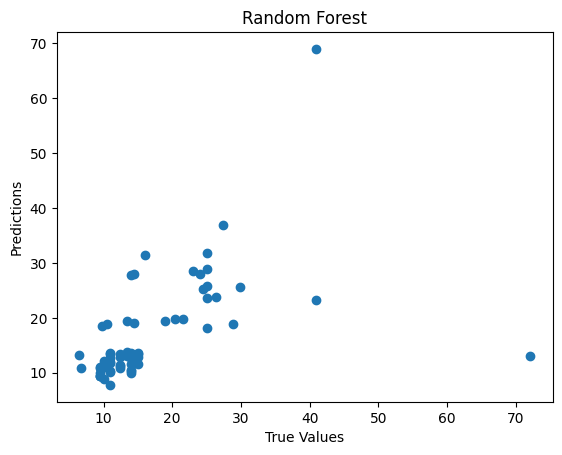

In [30]:
# plotting the results
plot_predictions(y_test, rf_y_pred, 'Random Forest')

In [31]:
# dataframe with the predictions and the actual values, plus other metrics
rf_results = pd.DataFrame({'Actual': y_test, 'Predicted': rf_y_pred})
rf_results['Difference'] = rf_results['Actual'] - rf_results['Predicted']
rf_results['Absolute Difference'] = np.abs(rf_results['Difference'])
rf_results['Squared Difference'] = rf_results['Difference'] ** 2

rf_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
591,14.4231,27.942805,-13.519705,13.519705,182.782423
541,20.4327,19.740223,0.692477,0.692477,0.479524
615,11.0000,10.105708,0.894292,0.894292,0.799758
411,24.0000,27.904583,-3.904583,3.904583,15.245768
513,14.0000,10.389500,3.610500,3.610500,13.035710
...,...,...,...,...,...
649,16.0000,31.352036,-15.352036,15.352036,235.685009
467,11.0000,11.699500,-0.699500,0.699500,0.489300
713,13.9423,27.808954,-13.866654,13.866654,192.284093
684,11.0000,13.384500,-2.384500,2.384500,5.685840


In [32]:
# printing the average absolute difference
print(f'Average Absolute Difference: {rf_results["Absolute Difference"].mean()}')

Average Absolute Difference: 4.63213051948718


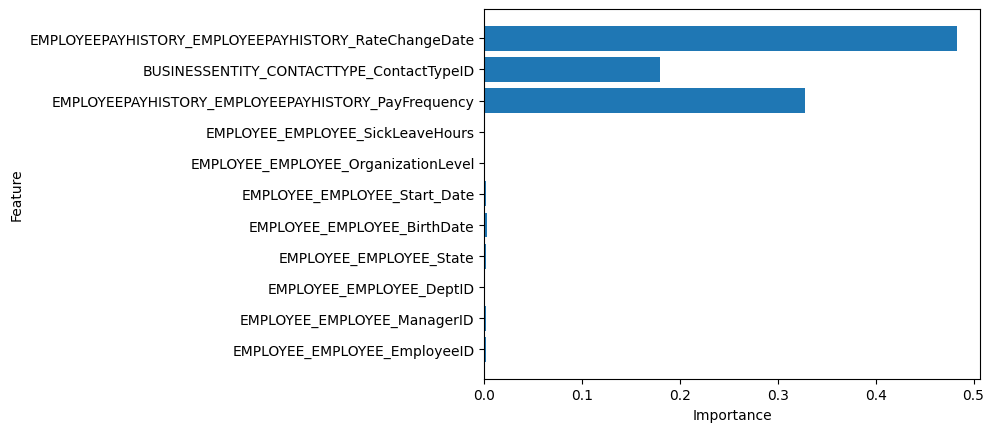

In [33]:
# plotting the feature importances, which means how much each column contributes to the predictions
plot_feature_importance(X.columns, rf_model.feature_importances_)

### Gradient Boosting

In [34]:
# fitting the model
gb_model = GradientBoostingRegressor(n_estimators=100)

gb_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor()

In [35]:
# predicting the values
gb_y_pred = gb_model.predict(X_test_scaled)

#### Calculating the metrics and visualizing the results

In [36]:
# calculating the metrics
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)
print(f'Mean Squared Error: {gb_mse}')
print(f'R2 Score: {gb_r2}')

Mean Squared Error: 73.13110358783159
R2 Score: 0.28415376645943746


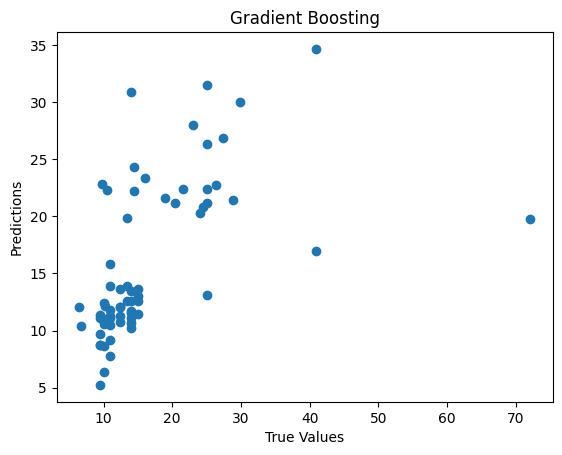

In [37]:
# plotting the results
plot_predictions(y_test, gb_y_pred, 'Gradient Boosting')

In [38]:
# dataframe with the predictions and the actual values, plus other metrics
gb_results = pd.DataFrame({'Actual': y_test, 'Predicted': gb_y_pred})
gb_results['Difference'] = gb_results['Actual'] - gb_results['Predicted']
gb_results['Absolute Difference'] = np.abs(gb_results['Difference'])
gb_results['Squared Difference'] = gb_results['Difference'] ** 2

gb_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
591,14.4231,24.300945,-9.877845,9.877845,97.571823
541,20.4327,21.178018,-0.745318,0.745318,0.555498
615,11.0000,10.481746,0.518254,0.518254,0.268587
411,24.0000,20.253893,3.746107,3.746107,14.033315
513,14.0000,10.620617,3.379383,3.379383,11.420230
...,...,...,...,...,...
649,16.0000,23.333942,-7.333942,7.333942,53.786699
467,11.0000,7.751276,3.248724,3.248724,10.554208
713,13.9423,30.849446,-16.907146,16.907146,285.851593
684,11.0000,13.870826,-2.870826,2.870826,8.241642


In [39]:
# printing the average absolute difference
print(f'Average Absolute Difference: {gb_results["Absolute Difference"].mean()}')

Average Absolute Difference: 4.403697444591302


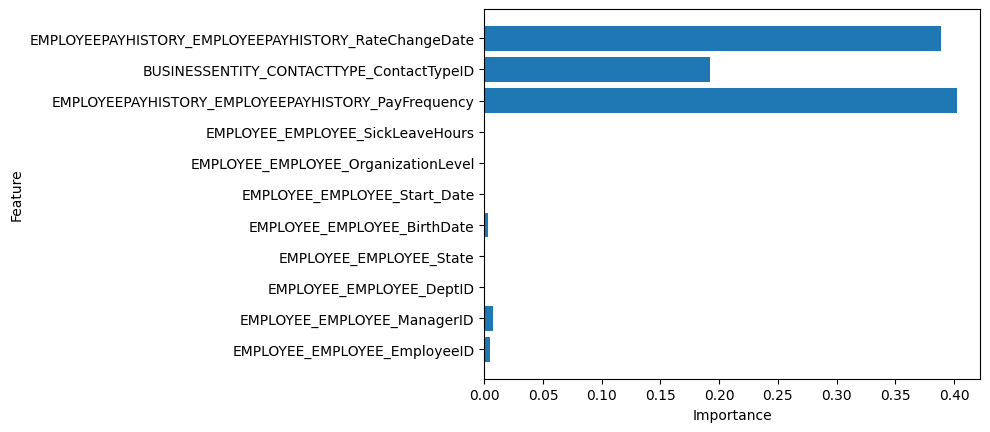

In [40]:
# plotting the feature importances, which means how much each column contributes to the predictions
plot_feature_importance(X.columns, gb_model.feature_importances_)

### Pytorch Neural Network

In [41]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# converting the scaled data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)  # target variable often doesn't need scaling
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

Using device: cuda


In [62]:
# instantiate the model
p_model = torch.nn.Sequential(
    torch.nn.Linear(X_train_tensor.shape[1], 48),
    torch.nn.ReLU(),
    torch.nn.Linear(48, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1)
).to(device)

# define the loss function and the optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(p_model.parameters(), lr=0.01)

# Create TensorDatasets for training and test data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders for training and test data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Train the model
train_model(p_model, criterion, optimizer, train_loader, num_epochs=1000)

Epoch 0, Loss: 423.6079406738281
Epoch 100, Loss: 38.4290771484375
Epoch 200, Loss: 56.8983039855957
Epoch 300, Loss: 110.56600952148438
Epoch 400, Loss: 48.243167877197266
Epoch 500, Loss: 18.261859893798828
Epoch 600, Loss: 55.744720458984375
Epoch 700, Loss: 27.503345489501953
Epoch 800, Loss: 33.21880340576172
Epoch 900, Loss: 34.34529113769531


#### Calculating the metrics and visualizing the results

In [63]:
# Evaluate the model
p_model.eval()
p_mse_list = []
p_r2_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = p_model(inputs)
        mse = mean_squared_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        p_mse_list.append(mse)
        
        # Only calculate R^2 score if there are more than one samples
        if len(targets) > 1:
            r2 = r2_score(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy())
            p_r2_list.append(r2)

# Calculate the average metrics
p_avg_mse = np.mean(p_mse_list)
p_avg_r2 = np.mean(p_r2_list) if p_r2_list else None

print(f'Average Mean Squared Error: {p_avg_mse}')
print(f'Average R2 Score: {p_avg_r2}')

Average Mean Squared Error: 53.05322265625
Average R2 Score: 0.21934574842453003


In [64]:
# dataframe with the predictions and the actual values, plus other metrics
p_results = pd.DataFrame({'Actual': y_test_tensor.cpu().detach().numpy(), 'Predicted': p_model(X_test_tensor).cpu().detach().numpy().flatten()})
p_results['Difference'] = p_results['Actual'] - p_results['Predicted']
p_results['Absolute Difference'] = np.abs(p_results['Difference'])
p_results['Squared Difference'] = p_results['Difference'] ** 2

p_results

,Actual,Predicted,Difference,Absolute Difference,Squared Difference
0,14.423100,24.473248,-10.050147,10.050147,101.005455
1,20.432699,19.536928,0.895771,0.895771,0.802406
2,11.000000,10.321110,0.678890,0.678890,0.460892
3,24.000000,24.676659,-0.676659,0.676659,0.457867
4,14.000000,11.107859,2.892141,2.892141,8.364482
...,...,...,...,...,...
60,16.000000,24.512470,-8.512470,8.512470,72.462151
61,11.000000,11.066315,-0.066315,0.066315,0.004398
62,13.942300,18.896954,-4.954654,4.954654,24.548594
63,11.000000,11.810640,-0.810640,0.810640,0.657138


In [65]:
# printing the average absolute difference
print(f'Average Absolute Difference: {p_results["Absolute Difference"].mean()}')

Average Absolute Difference: 4.454318046569824


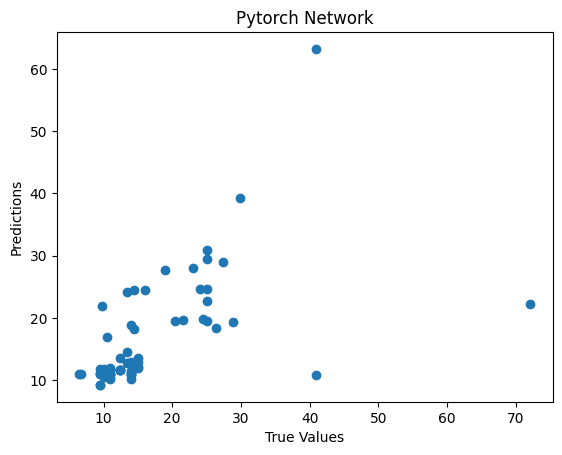

In [66]:
# plotting the feature results
plot_predictions(y_test_tensor.cpu().detach().numpy(), p_model(X_test_tensor).cpu().detach().numpy().flatten(), 'Pytorch Network')